In [30]:
# 读取配置
from lib.dataread import *
from lib.tools import *
from models.nerulforcastmodels import ex_Model,model_losss,brent_export_pdf,tansuanli_export_pdf,pp_export_pdf,model_losss_juxiting

import glob
import torch
torch.set_float32_matmul_precision("high")

sqlitedb = SQLiteHandler(db_name) 
sqlitedb.connect()

signature = BinanceAPI(APPID, SECRET)
etadata = EtaReader(signature=signature,
                        classifylisturl = classifylisturl,
                        classifyidlisturl=classifyidlisturl,
                        edbcodedataurl=edbcodedataurl,
                        edbcodelist=edbcodelist,
                        edbdatapushurl=edbdatapushurl,
                        edbdeleteurl=edbdeleteurl,
                        edbbusinessurl=edbbusinessurl
                        )
# 获取数据
if is_eta:
    # eta数据
    logger.info('从eta获取数据...')
    signature = BinanceAPI(APPID, SECRET)
    etadata = EtaReader(signature=signature,
                                classifylisturl = classifylisturl,
                                classifyidlisturl=classifyidlisturl,
                                edbcodedataurl=edbcodedataurl,
                                edbcodelist=edbcodelist,
                                edbdatapushurl=edbdatapushurl,
                                edbdeleteurl=edbdeleteurl,
                                edbbusinessurl=edbbusinessurl,
                                )
    df_zhibiaoshuju,df_zhibiaoliebiao =  etadata.get_eta_api_pp_data(data_set=data_set,dataset=dataset)  # 原始数据，未处理

    # 数据处理
    df = datachuli_juxiting(df_zhibiaoshuju,df_zhibiaoliebiao,y = y,dataset=dataset,add_kdj=add_kdj,is_timefurture=is_timefurture,end_time=end_time) 

else:
    logger.info('读取本地数据：'+os.path.join(dataset,data_set))
    df = getdata_juxiting(filename=os.path.join(dataset,data_set),y=y,dataset=dataset,add_kdj=add_kdj,is_timefurture=is_timefurture,end_time=end_time)  # 原始数据，未处理

# 更改预测列名称
df.rename(columns={y:'y'},inplace=True)
    
if is_edbnamelist:
    df = df[edbnamelist]     
df.to_csv(os.path.join(dataset,'指标数据.csv'), index=False)




读取本地数据：juxitingdataset\PP指标数据.xlsx
读取本地数据：juxitingdataset\PP指标数据.xlsx
getdata接收：juxitingdataset\PP指标数据.xlsx date 
getdata接收：juxitingdataset\PP指标数据.xlsx date 
删除两月不更新特征前数据量：(2516, 354)
删除两月不更新特征前数据量：(2516, 354)
删除两月不更新特征后数据量：(2516, 312)
删除两月不更新特征后数据量：(2516, 312)
删除预测列为空值的行后数据量：(772, 312)
删除预测列为空值的行后数据量：(772, 312)
删除全为空值的列后数据量：(772, 312)
删除全为空值的列后数据量：(772, 312)
d:\code\PriceForecast\lib\dataread.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values.dropna(inplace=True,axis=0)
d:\code\PriceForecast\lib\dataread.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values.dropna(inplace=True,axis=0)
d:\code\PriceFor

<Figure size 1000x1000 with 0 Axes>

In [31]:
# 保存最新日期的y值到数据库
# 取第一行数据存储到数据库中
first_row = df[['ds','y']].tail(1)
# 将最新真实值保存到数据库
# if not sqlitedb.check_table_exists('trueandpredict'):
#     first_row.to_sql('trueandpredict',sqlitedb.connection,index=False)
# else:
#     for row in first_row.itertuples(index=False):
#         row_dict = row._asdict()
#         row_dict['ds'] = row_dict['ds'].strftime('%Y-%m-%d %H:%M:%S')
#         check_query = sqlitedb.select_data('trueandpredict',where_condition = f"ds = '{row.ds}'")
#         if len(check_query) > 0:
#             set_clause = ", ".join([f"{key} = '{value}'" for key, value in row_dict.items()])
#             sqlitedb.update_data('trueandpredict',set_clause,where_condition = f"ds = '{row.ds}'")
#             continue
#         sqlitedb.insert_data('trueandpredict',tuple(row_dict.values()),columns=row_dict.keys())




In [32]:
import datetime
# 判断当前日期是不是周一
is_weekday = datetime.datetime.now().weekday() == 1
if is_weekday:
    logger.info('今天是周一，更新预测模型')
    # 计算最近20天预测残差最低的模型名称

    model_results = sqlitedb.select_data('trueandpredict',order_by = "ds DESC",limit = "20")
    # 删除空值率为40%以上的列
    print(model_results.shape)
    model_results = model_results.dropna(thresh=len(model_results)*0.6,axis=1)
    model_results = model_results.dropna()
    print(model_results.shape)
    modelnames  = model_results.columns.to_list()[2:] 
    for col in model_results[modelnames].select_dtypes(include=['object']).columns:
        model_results[col] = model_results[col].astype(np.float32)
    # 计算每个预测值与真实值之间的偏差率
    for model in modelnames:
        model_results[f'{model}_abs_error_rate'] = abs(model_results['y'] - model_results[model]) / model_results['y']

    # 获取每行对应的最小偏差率值
    min_abs_error_rate_values = model_results.apply(lambda row: row[[f'{model}_abs_error_rate' for model in modelnames]].min(), axis=1)
    # 获取每行对应的最小偏差率值对应的列名
    min_abs_error_rate_column_name = model_results.apply(lambda row: row[[f'{model}_abs_error_rate' for model in modelnames]].idxmin(), axis=1)
    print(min_abs_error_rate_column_name)
    # 将列名索引转换为列名
    min_abs_error_rate_column_name = min_abs_error_rate_column_name.map(lambda x: x.split('_')[0])
    # 取出现次数最多的模型名称
    most_common_model = min_abs_error_rate_column_name.value_counts().idxmax()
    logger.info(f"最近20天预测残差最低的模型名称：{most_common_model}")

    # 保存结果到数据库
    
    if not sqlitedb.check_table_exists('most_model'):
        sqlitedb.create_table('most_model',columns="ds datetime, most_common_model TEXT")
    sqlitedb.insert_data('most_model',(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),most_common_model,),columns=('ds','most_common_model',))



In [33]:
if is_corr:
    df = corr_feature(df=df)

df1 = df.copy()  # 备份一下，后面特征筛选完之后加入ds y 列用
logger.info(f"开始训练模型...")
row,col = df.shape


开始训练模型...
开始训练模型...


In [34]:
now = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
# ex_Model(df,
#         horizon=horizon,
#         input_size=input_size,
#         train_steps=train_steps,
#         val_check_steps=val_check_steps,
#         early_stop_patience_steps=early_stop_patience_steps,
#         is_debug=is_debug,
#         dataset=dataset,
#         is_train=is_train,
#         is_fivemodels=is_fivemodels,
#         val_size=val_size,
#         test_size=test_size,
#         settings=settings,
#         now=now,
#         etadata = etadata,
#         modelsindex = modelsindex,
#         data = data,
#         is_eta=is_eta,
#         )


模型训练完成
模型训练完成
训练数据绘图ing
训练数据绘图ing
C:\Users\EDY\AppData\Local\Temp\ipykernel_19344\3035235873.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  names_df['columns'] = names_df.apply(add_rote_column, axis=1)


['NLinear', 'RNN', 'TiDE', 'TSMixer', 'PatchTST', 'NHITS', 'DilatedRNN', 'DLinear', 'GRU', 'LSTM', 'Informer', 'DeepNPTS', 'MLP', 'TFT', 'TSMixerx', 'BiTCN', 'TCN', 'iTransformer', 'StemGNN', 'MLPMultivariate']
<class 'list'>
['NLinear', 'RNN', 'TiDE', 'TSMixer', 'PatchTST', 'NHITS', 'DilatedRNN', 'DLinear', 'GRU', 'LSTM', 'Informer', 'DeepNPTS', 'MLP', 'TFT', 'TSMixerx', 'BiTCN', 'TCN', 'iTransformer', 'StemGNN', 'MLPMultivariate']
<class 'list'>
['NLinear', 'RNN', 'TiDE', 'TSMixer', 'PatchTST', 'NHITS', 'DilatedRNN', 'DLinear', 'GRU', 'LSTM', 'Informer', 'DeepNPTS', 'MLP', 'TFT', 'TSMixerx', 'BiTCN', 'TCN', 'iTransformer', 'StemGNN', 'MLPMultivariate']
<class 'list'>
['NLinear', 'RNN', 'TiDE', 'TSMixer', 'PatchTST', 'NHITS', 'DilatedRNN', 'DLinear', 'GRU', 'LSTM', 'Informer', 'DeepNPTS', 'MLP', 'TFT', 'TSMixerx', 'BiTCN', 'TCN', 'iTransformer', 'StemGNN', 'MLPMultivariate']
<class 'list'>
['NLinear', 'RNN', 'TiDE', 'TSMixer', 'PatchTST', 'NHITS', 'DilatedRNN', 'DLinear', 'GRU', 'LSTM

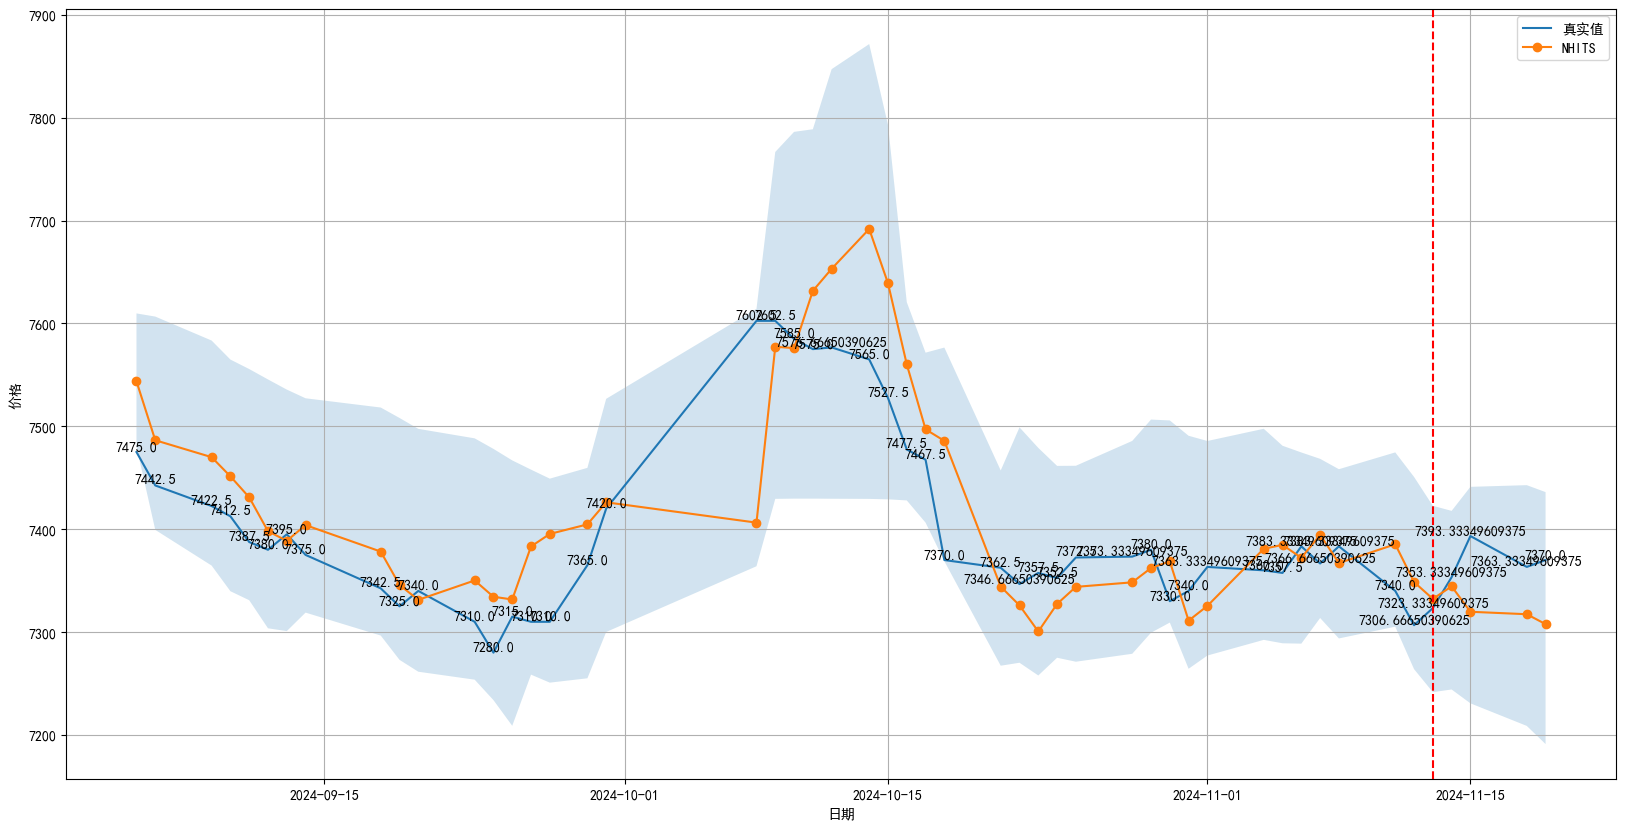

C:\Users\EDY\AppData\Local\Temp\ipykernel_19344\3035235873.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_row['ds'] = first_row['ds'].dt.strftime('%Y-%m-%d 00:00:00')
更新数据sqlUPDATE trueandpredict SET ds = '2024-11-20 00:00:00', NHITS = '7337.594', Informer = '7316.5264', LSTM = '7313.051', iTransformer = '7342.468', TSMixer = '7344.392', TSMixerx = '7306.8916', PatchTST = '7350.6377', RNN = '7378.303', GRU = '7405.318', TCN = '7418.5396', BiTCN = '7321.0723', DilatedRNN = '7320.571', MLP = '7338.035', DLinear = '7387.8057', NLinear = '7361.405', TFT = '7362.294', StemGNN = '7351.2534', MLPMultivariate = '7331.5254', TiDE = '7354.707', DeepNPTS = '7376.7446' WHERE ds = '2024-11-20 00:00:00'
更新数据sqlUPDATE trueandpredict SET ds = '2024-

Column 'ds' already exists in table 'trueandpredict'.
Column 'NHITS' already exists in table 'trueandpredict'.
Column 'Informer' already exists in table 'trueandpredict'.
Column 'LSTM' already exists in table 'trueandpredict'.
Column 'iTransformer' already exists in table 'trueandpredict'.
Column 'TSMixer' already exists in table 'trueandpredict'.
Column 'TSMixerx' already exists in table 'trueandpredict'.
Column 'PatchTST' already exists in table 'trueandpredict'.
Column 'RNN' already exists in table 'trueandpredict'.
Column 'GRU' already exists in table 'trueandpredict'.
Column 'TCN' already exists in table 'trueandpredict'.
Column 'BiTCN' already exists in table 'trueandpredict'.
Column 'DilatedRNN' already exists in table 'trueandpredict'.
Column 'MLP' already exists in table 'trueandpredict'.
Column 'DLinear' already exists in table 'trueandpredict'.
Column 'NLinear' already exists in table 'trueandpredict'.
Column 'TFT' already exists in table 'trueandpredict'.
Column 'StemGNN' a

训练数据绘图end
训练数据绘图end


In [43]:
logger.info('模型训练完成')
# # 模型评估

pd.set_option('display.max_columns', 100)

# 计算预测评估指数
def model_losss_juxiting(sqlitedb):
    global dataset
    most_model = [sqlitedb.select_data('most_model',columns=['most_common_model'],order_by='ds desc',limit=1).values[0][0]]
    most_model_name = most_model[0]

    # 预测数据处理 predict
    df_combined = loadcsv(os.path.join(dataset,"cross_validation.csv"))  
    df_combined = dateConvert(df_combined)
    # 删除空列
    df_combined.dropna(axis=1,inplace=True)
     # 删除缺失值,预测过程不能有缺失值
    df_combined.dropna(inplace=True) 
    # 其他列转为数值类型
    df_combined = df_combined.astype({col: 'float32' for col in df_combined.columns if col not in ['cutoff','ds'] })
    # 使用 groupby 和 transform 结合 lambda 函数来获取每个分组中 cutoff 的最小值，并创建一个新的列来存储这个最大值
    df_combined['max_cutoff'] = df_combined.groupby('ds')['cutoff'].transform('max')

    # 然后筛选出那些 cutoff 等于 max_cutoff 的行，这样就得到了每个分组中 cutoff 最大的行，并保留了其他列
    df_combined = df_combined[df_combined['cutoff'] == df_combined['max_cutoff']]
    # 删除模型生成的cutoff列
    df_combined.drop(columns=['cutoff', 'max_cutoff'], inplace=True)
    # 获取模型名称
    modelnames  = df_combined.columns.to_list()[1:] 
    if 'y' in modelnames:
        modelnames.remove('y')
    df_combined3 = df_combined.copy()  # 备份df_combined,后面画图需要


    # 空的列表存储每个模型的MSE、RMSE、MAE、MAPE、SMAPE
    cellText = []

    # 遍历模型名称，计算模型评估指标  
    for model in modelnames:
        modelmse = mse(df_combined['y'], df_combined[model])
        modelrmse = rmse(df_combined['y'], df_combined[model])
        modelmae = mae(df_combined['y'], df_combined[model])
        # modelmape = mape(df_combined['y'], df_combined[model])
        # modelsmape = smape(df_combined['y'], df_combined[model])
        # modelr2 = r2_score(df_combined['y'], df_combined[model])
        cellText.append([model,round(modelmse, 3), round(modelrmse, 3), round(modelmae, 3)])
        
    model_results3 = pd.DataFrame(cellText,columns=['模型(Model)','平均平方误差(MSE)', '均方根误差(RMSE)',  '平均绝对误差(MAE)'])
    # 按MSE降序排列
    model_results3 = model_results3.sort_values(by='平均平方误差(MSE)', ascending=True)
    model_results3.to_csv(os.path.join(dataset,"model_evaluation.csv"),index=False)
    modelnames = model_results3['模型(Model)'].tolist()
    allmodelnames = modelnames.copy()
    # 保存5个最佳模型的名称
    if len(modelnames) > 5:
        modelnames = modelnames[0:5]
    with open(os.path.join(dataset,"best_modelnames.txt"), 'w') as f:
        f.write(','.join(modelnames) + '\n')

    def plot_predict_vs_true():
        # 预测值与真实值对比图
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.figure(figsize=(15, 10))
        for n,model in enumerate(modelnames[:5]):
            plt.subplot(3, 2, n+1)
            plt.plot(df_combined3['ds'], df_combined3['y'], label='真实值')
            plt.plot(df_combined3['ds'], df_combined3[model], label=model)
            plt.legend()
            plt.xlabel('日期')
            plt.ylabel('价格')
            plt.title(model+'拟合')
        plt.subplots_adjust(hspace=0.5)
        plt.savefig(os.path.join(dataset,'预测值与真实值对比图.png'), bbox_inches='tight')
        plt.close()
    
    plot_predict_vs_true()
    
    
    '''
    # # 根据最佳模型的绝对误差的平均比例，最佳模型乘平均比例的百分比，确定最大最小值
    # 计算最佳模型对应的绝对误差的平均比例
    most_model_mae = model_results3[model_results3['模型(Model)']==most_model_name]['平均绝对误差(MAE)'].values[0]
    
    def mae_upper_lower(row):
        # 计算上边界值
        upper_bound = row[most_model_name] * (1 + most_model_mae/row[most_model_name])
        # 计算下边界值
        lower_bound = row[most_model_name] * (1 - most_model_mae/row[most_model_name])
        return pd.Series([lower_bound, upper_bound], index=['lower_bound', 'upper_bound'])
    
    df_combined3[['upper_bound', 'lower_bound']] = df_combined3.apply(mae_upper_lower, axis=1)
    '''
    
    # 每个模型的绝对值
    # names = []
    # for col in allmodelnames:
    # df_combined3[f'{col}-{most_model_name}-误差比例'] = abs(df_combined3[col] - df_combined3[most_model_name]) / df_combined3[most_model_name] * 100
        

    # # 设置阈值 rote
    # rote = 1.5
    # names_df = df_combined3[names]
    # # names_df['rote'] = rote
    # def add_rote_column(row):
    #     columns = []
    #     for r in names_df.columns:
    #         if row[r] <= rote:
    #             columns.append(r.split('-')[0])
    #     return pd.Series([columns], index=['columns'])
    # names_df['columns'] = names_df.apply(add_rote_column, axis=1)
    
    # def add_upper_lower_bound(row):
    #     print(row['columns'])
    #     print(type(row['columns']))
    #     # 计算上边界值
    #     upper_bound = df_combined3.loc[row.name,row['columns']].max()
    #     # 计算下边界值
    #     lower_bound = df_combined3.loc[row.name,row['columns']].min()
    #     return pd.Series([lower_bound, upper_bound], index=['lower_bound', 'upper_bound'])
    # df_combined3[['upper_bound','lower_bound']] = names_df.apply(add_upper_lower_bound, axis=1)
    
    # print(df_combined3[['ds','y',most_model_name,'upper_bound','lower_bound']])
    
    
    
    
    
    # '''
    # 计算每个模型与最佳模型的绝对误差比例
    names = []
    for col in allmodelnames:
        df_combined3[f'{col}-{most_model_name}-误差比例'] = abs(df_combined3[col] - df_combined3[most_model_name]) / df_combined3[most_model_name]
        names.append(f'{col}-{most_model_name}-误差比例')

    # 设置阈值 rote
    rote = 0.04
    names_df = df_combined3[names]
    # names_df['rote'] = rote
    def add_rote_column(row):
        columns = []
        for r in names_df.columns:
            if row[r] <= rote:
                columns.append(r.split('-')[0])
        return pd.Series([columns], index=['columns'])
    names_df['columns'] = names_df.apply(add_rote_column, axis=1)
    
    def add_upper_lower_bound(row):
        print(row['columns'])
        print(type(row['columns']))
        # 计算上边界值
        upper_bound = df_combined3.loc[row.name,row['columns']].max()
        # 计算下边界值
        lower_bound = df_combined3.loc[row.name,row['columns']].min()
        return pd.Series([lower_bound, upper_bound], index=['lower_bound', 'upper_bound'])
    df_combined3[['upper_bound','lower_bound']] = names_df.apply(add_upper_lower_bound, axis=1)
    
    print(df_combined3[['ds','y',most_model_name,'upper_bound','lower_bound']])
    # '''
    
    
    '''
    # 计算波动率,取近60日波动率的10%和90%分位数确定通道上下界
    df_combined3['volatility'] = df_combined3['y'].pct_change().round(4)
    # 计算近60日的波动率 10% 90%分位数
    df_combined3['quantile_10'] = df_combined3['volatility'].rolling(60).quantile(0.1)
    df_combined3['quantile_90'] = df_combined3['volatility'].rolling(60).quantile(0.9)
    df_combined3 = df_combined3.round(4)
    # 计算分位数对应的价格
    df_combined3['quantile_10_price'] = df_combined3['y'] * (1 + df_combined3['quantile_10'])
    df_combined3['quantile_90_price'] = df_combined3['y'] * (1 + df_combined3['quantile_90'])

    # 遍历行
    def find_min_max_within_quantile(row):
        # 获取分位数10%和90%的值
        q10 = row['quantile_10_price']
        q90 = row['quantile_90_price']
        
        # 判断flot值是否为空值
        if pd.isna(q10) or pd.isna(q90):
            return pd.Series([None, None, None, None], index=['min_within_quantile','max_within_quantile','min_model','max_model'])
        
        # 初始化最小和最大值为None
        min_value = None
        max_value = None
        min_value_model = ''
        max_value_model = ''

        # 遍历指定列，找出在分位数范围内的最大最小值
        for model in modelnames:
            value = row[model]
            if value >= q10 and value <= q90:
                if min_value is None or value < min_value:
                    min_value = value
                    min_value_model = model

                if max_value is None or value > max_value:
                    max_value = value
                    max_value_model = model
        
        # 返回最大最小值
        return pd.Series([min_value, max_value,min_value_model,max_value_model], index=['min_within_quantile', 'max_within_quantile','min_model','max_model'])

    # 应用函数到每一行
    df_combined3[['min_within_quantile', 'max_within_quantile','min_model','max_model']] = df_combined3.apply(find_min_max_within_quantile, axis=1)

    
    '''
    
    # 去除有空值的行
    df_combined3.dropna(inplace=True)
    # 保存到数据库
    # df_combined3.to_sql('testandpredict_groupby', sqlitedb.connection, if_exists='replace', index=False)
    df_combined3.to_csv(os.path.join(dataset,"testandpredict_groupby.csv"),index=False)

    
    def _plt_predict_ture(df):
        df = df[-50:] # 取50个数据点画图
        # 历史价格
        plt.figure(figsize=(20, 10))
        plt.plot(df['ds'], df['y'], label='真实值')
        # 颜色填充
        # plt.fill_between(df['ds'], df['min_within_quantile'], df['max_within_quantile'], alpha=0.2)
        plt.fill_between(df['ds'], df['upper_bound'], df['lower_bound'], alpha=0.2)
        # plt.plot(df_combined3['ds'], df_combined3['min_abs_error_rate_prediction'], label='最小绝对误差', linestyle='--', color='orange')
        # 网格
        plt.grid(True)
        # 显示历史值
        for i, j in zip(df['ds'], df['y']):
            plt.text(i, j, str(j), ha='center', va='bottom')

        for model in most_model:
            plt.plot(df['ds'], df[model], label=model,marker='o')
        # 当前日期画竖虚线
        plt.axvline(x=df['ds'].iloc[-horizon], color='r', linestyle='--')
        plt.legend()
        plt.xlabel('日期')
        plt.ylabel('价格')
        
        plt.savefig(os.path.join(dataset,'历史价格-预测值.png'), bbox_inches='tight')
        plt.show()
        plt.close()

    _plt_predict_ture(df_combined3)

    '''
   # 去掉方差最大的模型，其余模型预测最大最小值确定通道边界
    
    
    # 历史数据+预测数据
    # 拼接未来时间预测
    df_predict  = loadcsv(os.path.join(dataset,'predict.csv'))
    df_predict.drop('unique_id',inplace=True,axis=1)
    df_predict.dropna(axis=1,inplace=True)
    df_predict2 = df_predict.copy()
    try:
        df_predict['ds'] = pd.to_datetime(df_predict['ds'],format=r'%Y-%m-%d')
    except ValueError :
        df_predict['ds'] = pd.to_datetime(df_predict['ds'],format=r'%Y/%m/%d')

    # 取第一行数据存储到数据库中
    first_row = df_predict.head(1)
    first_row['ds'] = first_row['ds'].dt.strftime('%Y-%m-%d 00:00:00')

    # # 将预测结果保存到数据库
    df_combined3 = pd.concat([df_combined3, df_predict]).reset_index(drop=True)
    # # 判断 df 的数值列转为float
    for col in df_combined3.columns:
        try:
            if col != 'ds':
                df_combined3[col] = df_combined3[col].astype(float)
                df_combined3[col] = df_combined3[col].round(2)
        except ValueError:
            pass
    df_combined3.to_csv(os.path.join(dataset,"testandpredict_groupby.csv"),index=False)
    df_combined3['ds'] = df_combined3['ds'].dt.strftime('%Y-%m-%d 00:00:00')
    # # 判断表存在
    if not sqlitedb.check_table_exists('testandpredict_groupby'):
        df_combined3.to_sql('testandpredict_groupby',sqlitedb.connection,index=False)
    else:
        for row in df_combined3.itertuples(index=False):
            row_dict = row._asdict()
            check_query = sqlitedb.select_data('testandpredict_groupby',where_condition = f"ds = '{row.ds}'")
            if len(check_query) > 0:
                set_clause = ", ".join([f"{key} = '{value}'" for key, value in row_dict.items()])
                sqlitedb.update_data('testandpredict_groupby',set_clause,where_condition = f"ds = '{row.ds}'")
                continue
            sqlitedb.insert_data('testandpredict_groupby',tuple(row_dict.values()),columns=row_dict.keys())

    ten_models = allmodelnames
    # 计算每个模型的方差
    variances = df_combined3[ten_models].var()
    # 找到方差最大的模型
    max_variance_model = variances.idxmax()
    # 打印方差最大的模型
    print("方差最大的模型是：", max_variance_model)
    # 去掉方差最大的模型
    df_combined3 = df_combined3.drop(columns=[max_variance_model])
    if max_variance_model in allmodelnames:
        allmodelnames.remove(max_variance_model)
    df_combined3['min'] = df_combined3[allmodelnames].min(axis=1)
    df_combined3['max'] = df_combined3[allmodelnames].max(axis=1)
    print(df_combined3[['min','max']])
    # 历史价格+预测价格
    df_combined3 = df_combined3[-50:] # 取50个数据点画图
    plt.figure(figsize=(20, 10))
    plt.plot(df_combined3['ds'], df_combined3['y'], label='真实值',marker='o')
    plt.plot(df_combined3['ds'], df_combined3[most_model], label=most_model_name)
    plt.fill_between(df_combined3['ds'], df_combined3['min'], df_combined3['max'], alpha=0.2)
    plt.grid(True)
    # # 显示历史值
    for i, j in zip(df_combined3['ds'][:-5], df_combined3['y'][:-5]):
        plt.text(i, j, str(j), ha='center', va='bottom')
    # 当前日期画竖虚线
    plt.axvline(x=df_combined3['ds'].iloc[-horizon], color='r', linestyle='--')
    plt.legend()
    plt.xlabel('日期')
    plt.ylabel('价格')

    plt.savefig(os.path.join(dataset,'历史价格-预测值.png'), bbox_inches='tight')
    plt.close()
    '''

    # # 历史数据+预测数据
    # # 拼接未来时间预测
    df_predict  = pd.read_csv(os.path.join(dataset,'predict.csv'))
    df_predict.drop('unique_id',inplace=True,axis=1)
    df_predict.dropna(axis=1,inplace=True)

    try:
        df_predict['ds'] = pd.to_datetime(df_predict['ds'],format=r'%Y-%m-%d')
    except ValueError :
        df_predict['ds'] = pd.to_datetime(df_predict['ds'],format=r'%Y/%m/%d')

    def first_row_to_database(df):
        # # 取第一行数据存储到数据库中
        first_row = df.head(1)
        first_row['ds'] = first_row['ds'].dt.strftime('%Y-%m-%d 00:00:00')
        # 将预测结果保存到数据库
        if not sqlitedb.check_table_exists('trueandpredict'):
            first_row.to_sql('trueandpredict',sqlitedb.connection,index=False)
        else:
            for col in first_row.columns:
                    sqlitedb.add_column_if_not_exists('trueandpredict',col,'TEXT')
            for row in first_row.itertuples(index=False):
                row_dict = row._asdict()
                columns=row_dict.keys()
                check_query = sqlitedb.select_data('trueandpredict',where_condition = f"ds = '{row.ds}'")
                if len(check_query) > 0:
                    set_clause = ", ".join([f"{key} = '{value}'" for key, value in row_dict.items()])
                    sqlitedb.update_data('trueandpredict',set_clause,where_condition = f"ds = '{row.ds}'")
                    continue
                sqlitedb.insert_data('trueandpredict',tuple(row_dict.values()),columns=columns)

    first_row_to_database(df_predict)
    def find_most_common_model():
        # 最多频率的模型名称
        min_model_max_frequency_model = df_combined3['min_model'].tail(20).value_counts().idxmax()
        max_model_max_frequency_model = df_combined3['max_model'].tail(20).value_counts().idxmax()
        if min_model_max_frequency_model == max_model_max_frequency_model:
            # 取20天第二多的模型
            max_model_max_frequency_model = df_combined3['max_model'].tail(20).value_counts().nlargest(2).index[1]

        df_predict['min_model'] = min_model_max_frequency_model
        df_predict['max_model'] = max_model_max_frequency_model
        df_predict['min_within_quantile'] = df_predict[min_model_max_frequency_model]
        df_predict['max_within_quantile'] = df_predict[max_model_max_frequency_model]


    # find_most_common_model()

    df_predict2 = df_predict.copy()
    df_predict2['ds'] = pd.to_datetime(df_predict2['ds'])
    df_predict2['ds'] = df_predict2['ds'].dt.strftime('%Y-%m-%d 00:00:00')


    def _add_abs_error_rate():
        # 计算每个预测值与真实值之间的偏差率
        for model in allmodelnames:
            df_combined3[f'{model}_abs_error_rate'] = abs(df_combined3['y'] - df_combined3[model]) / df_combined3['y']

        # 获取每行对应的最小偏差率值
        min_abs_error_rate_values = df_combined3.apply(lambda row: row[[f'{model}_abs_error_rate' for model in allmodelnames]].min(), axis=1)
        # 获取每行对应的最小偏差率值对应的列名
        min_abs_error_rate_column_name = df_combined3.apply(lambda row: row[[f'{model}_abs_error_rate' for model in allmodelnames]].idxmin(), axis=1) 
        # 将列名索引转换为列名
        min_abs_error_rate_column_name = min_abs_error_rate_column_name.map(lambda x: x.split('_')[0])
        # 获取最小偏差率对应的模型的预测值
        min_abs_error_rate_predictions = df_combined3.apply(lambda row: row[min_abs_error_rate_column_name[row.name]], axis=1)
        # 将最小偏差率对应的模型的预测值添加到DataFrame中
        df_combined3['min_abs_error_rate_prediction'] = min_abs_error_rate_predictions
        df_combined3['min_abs_error_rate_column_name'] = min_abs_error_rate_column_name

    _add_abs_error_rate()

    df_combined3 = pd.concat([df_combined3, df_predict]).reset_index(drop=True)
    # 判断 df 的数值列转为float
    for col in df_combined3.columns:
        try:
            if col != 'ds':
                df_combined3[col] = df_combined3[col].astype(float)
                df_combined3[col] = df_combined3[col].round(2)
        except ValueError:
            pass
    df_combined3.to_csv(os.path.join(dataset,"df_combined3.csv"),index=False) 
    
     # 历史价格+预测价格
        # 将预测结果保存到数据库
    # 判断表存在
    # if not sqlitedb.check_table_exists('testandpredict_groupby'):
    #     df_combined3.to_sql('testandpredict_groupby',sqlitedb.connection,index=False)
    # else:
    #     for row in df_combined3.itertuples(index=False):
    #         row_dict = row._asdict()
    #         check_query = sqlitedb.select_data('testandpredict_groupby',where_condition = f"ds = '{row.ds}'")
    #         if len(check_query) > 0:
    #             set_clause = ", ".join([f"{key} = '{value}'" for key, value in row_dict.items()])
    #             sqlitedb.update_data('testandpredict_groupby',set_clause,where_condition = f"ds = '{row.ds}'")
    #             continue
    #         sqlitedb.insert_data('testandpredict_groupby',tuple(row_dict.values()),columns=row_dict.keys())
    
    

    def _plt_predict_table(df): 
        # 预测值表格
        fig, ax = plt.subplots(figsize=(20, 6))
        ax.axis('off')  # 关闭坐标轴
        # 数值保留2位小数
        df = df.round(2)
        df = df[-horizon:]
        df['Day'] = [f'Day_{i}' for i in range(1,horizon+1)]
        # Day列放到最前面
        df = df[['Day'] + list(df.columns[:-1])]
        table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
        #加宽表格
        table.auto_set_font_size(False)
        table.set_fontsize(10)

        # 设置表格样式，列数据最小的用绿色标识
        plt.savefig(os.path.join(dataset,'预测值表格.png'), bbox_inches='tight')
        plt.close()
       
    def _plt_model_results3():
        # 可视化评估结果
        plt.rcParams['font.sans-serif'] = ['SimHei']
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.axis('off')  # 关闭坐标轴
        table = ax.table(cellText=model_results3.values, colLabels=model_results3.columns, loc='center')
        # 加宽表格
        table.auto_set_font_size(False)
        table.set_fontsize(10)

        # 设置表格样式，列数据最小的用绿色标识
        plt.savefig(os.path.join(dataset,'模型评估.png'), bbox_inches='tight')
        plt.close()


    _plt_predict_table(df_combined3)
    _plt_model_results3()

    return model_results3



logger.info('训练数据绘图ing')
model_results3 = model_losss_juxiting(sqlitedb)

logger.info('训练数据绘图end')



In [36]:
# 模型报告

logger.info('制作报告ing')
title = f'{settings}--{now}-预测报告' # 报告标题

pp_export_pdf(dataset=dataset,num_models = 5 if is_fivemodels else 22,time=end_time,
        reportname=reportname,sqlitedb=sqlitedb),

logger.info('制作报告end')
logger.info('模型训练完成')

制作报告ing
制作报告ing
开始绘制价差类指标的相关性直方图
开始绘制价差类指标的相关性直方图
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


价差下正相关的特征值有： ['PP期货-丙烯价差（山东）/400DMA', 'PP-SC价差（7吨桶比）', '布伦特-PP价差（盘面）', '薄壁-拉丝价差（华北）', 'PP-FEI M4(含税成本)', '油制PP利润（华东）', 'PP-FEI M3(含税成本)', '价差：聚乙烯与乙烯（西北欧）', 'PP-FEI M2（含税成本）', 'PP-FEI M1（含税成本）', 'PP加权利润', '滨化PDH利润（1.169/含税）', 'PDH利润（山东/丙烯）', 'PP-FEI价差', '外采丙烯制聚丙烯利润（华东）', '5-9月差（PP）', '9-1月差（PP）']
正在绘制第1个特征PP期货-丙烯价差（山东）/400DMA与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征PP-SC价差（7吨桶比）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征布伦特-PP价差（盘面）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征薄壁-拉丝价差（华北）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征PP-FEI M4(含税成本)与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

价差下负相关的特征值有： ['L-P价差', 'L-P价差（盘面）', 'PDH制PP利润（山东）', '低熔共聚-拉丝价差（华南）', '外采丙烯制聚丙烯利润（山东）', 'PDH制PP利润（华南）', '京博-滨化价差（不含税/1.13/580）', 'PP现货-丙烯价差（山东）', 'PP-3MA价差（盘面）', 'PP-3*MA主力', '透明-PP盘面价差（华北）', '透明-拉丝价差（华北）', 'PP期货-丙烯价差（山东）', 'PDH制PP利润（华东）', 'PDH制PP利润（华东）指数修匀', '华东拉丝-CP', '透明-PP盘面（华东）', 'LPG-PP价差（盘面）', '拉丝区域价差（华东-华北）', '透明-拉丝价差（华东）', 'PP盘中基差（临沂）', 'PP基差（盘中）', '外采甲醇制PP利润（西北）', '拉丝区域价差（华南-华北）', '滨化丙烷-PP边际贡献（不含税/510/收率1.169）', '滨化丙烯-京博PP边际贡献（不含税/600/收率1.169）', '粉粒价差（山东）', '外采甲醇制PP利润（太仓）', '1-5月差（PP）', '滨化丙烷-PP边际贡献（不含税/580/收率1.13）', '山东拉丝-CP', '山东拉丝-丙烯价差', '拉丝区域价差（华南-华东）']
正在绘制第1个特征L-P价差与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征L-P价差（盘面）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征PDH制PP利润（山东）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征低熔共聚-拉丝价差（华南）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征外采丙烯制聚丙烯利润（山东）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

价格下正相关的特征值有： ['PP神华竞拍（临沂）', 'PP：拉丝：S1003：市场主流价：常州：国能榆林化工（日）', 'PP神华竞拍（华东）', 'BOPP：成本：中国（日）', 'PP：BOPP：1103K：出厂价：华北地区：国家能源宁煤（日）', 'PP拉丝国内现货价格', 'PP：BOPP：1103K：出厂价：华南地区：宁夏神华宁煤（日）', 'PP：BOPP：1103K：出厂价：华东地区：国家能源宁煤（日）', 'PP神华竞拍（西安）', 'PP：薄壁注塑：1040TE：出厂价：华东地区：宁夏神华宁煤（日）', 'PP：薄壁注塑：1040TE：出厂价：华南地区：宁夏神华宁煤（日）', 'PP主力盘中', 'PP：拉丝：S1003：市场主流价：东莞：宝丰能源（日）', 'PP：BOPP：PPH-F03D：出厂价：华南地区：海南炼化装置一（日）', 'PP粉料（山东）/拼接', 'PP.DCE收盘价', 'PP主力收盘价', 'PP无纺布生产成本（日）', 'PP：薄壁注塑：PPH-MN60：出厂价：华南地区：中石化北海（日）', 'PP：低熔共聚：K8003：出厂价：华东地区：东华能源（宁波）（日）', 'PP：薄壁注塑：BZ-70：出厂价：华北地区：寿光鲁清（日）', 'PP：中熔共聚：2043N：出厂价：华南地区：国家能源宁煤（日）', 'PP：中熔共聚：2043N：出厂价：华东地区：国家能源宁煤（日）', 'PP：薄壁注塑：TM6000H：出厂价：华南地区：福建联合石化（日）', 'PP：低熔共聚：2500H：市场价：厦门：国家能源宁煤（日）', 'PP：拉丝：1102K：市场价：临沂：国家能源宁煤（日）', 'PP：低熔共聚：K8003：自提价：广州：宝丰能源（日）', 'PP：透明：R3080T：出厂价：华东地区：浙江鸿基（日）', 'PP：中熔共聚：EP5010C：出厂价：华北地区：中沙天津（日）', 'PP：BOPP：PPH-FL03-S：出厂价：华北地区：青岛炼化（日）', 'PP：中熔共聚：SP179P：出厂价：华北地区：中石化齐鲁化工（日）', 'PP：拉丝：1102K：市场价：青州：国家能源宁煤（日）', 'PP：透明：R3260T：出厂价：华东地区：浙江鸿基（日）', 'PP：低熔共聚：K8003：自提价：宁波：国能榆林化工（日）

d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征PP：拉丝：S1003：市场主流价：常州：国能榆林化工（日）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征PP神华竞拍（华东）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征BOPP：成本：中国（日）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征PP：BOPP：1103K：出厂价：华北地区：国家能源宁煤（日）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

价格下负相关的特征值有： ['中国PP无纺布原料库存天数', '中国PP无纺布成品库存天数', '中国PP无纺布原料库存量', 'PP无纺布：厂内库存：中国（周）', '中国BOPP成品库存量', '中国BOPP成品库存天数', '印度粉矿：57%Fe：品牌价格：青岛港', 'PP：看跌比例：中国（周）', 'PP管材开工率', 'PP：低熔共聚：2500HY：市场价：临沂：国家能源宁煤（日）', '煤制聚丙烯利润', 'CPP：二元共聚膜：F08EC：出厂价：华东地区：镇海炼化（日）', 'PP：低熔共聚：K8003：出厂价：临沂：宝丰能源（日）', 'BOPP开工率', 'PP：低熔共聚：K8003：出厂价：常州：宝丰能源（日）', 'PP：低熔共聚：K8003：出厂价：河北、鲁北：大唐内蒙多伦（日）', '华北聚丙烯基差（折盘面收盘价）', 'DCE：工业产品：期货价格综合指数收盘价（日）']
正在绘制第1个特征中国PP无纺布原料库存天数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征中国PP无纺布成品库存天数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征中国PP无纺布原料库存量与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征PP无纺布：厂内库存：中国（周）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征中国BOPP成品库存量与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

供应下正相关的特征值有： ['PP开工率（1MMA）', 'PP周度开工率', 'PP开工率/7DMA', 'PP开工率/2WMA', 'PP日度开工率', 'PP/开工率/东北地区（日）', 'PP开工率/华中地区（日）', 'PP开工率/华南地区（日）', 'PP开工率/华北地区（日）', 'PP下游综合开工率（少注塑&CPP）', 'PP无纺布生产毛利', 'CPP：均聚：生产比例：中国（日）', 'PP：高熔纤维：生产比例：中国（日）', '中国再生PP周度开工负荷率同差', '冷水管：生产比例：中国（日）', 'PP粉料开工率（4WMA）', '中国再生PP周度开工负荷率', 'PP开工率/西北地区（日）', 'PP：拉丝：生产比例：中国（日）', 'BOPP开工率(隆众)同差', 'BOPP开工率同差', 'PP粉料开工率', 'PP：涂覆料：生产比例：中国（日）', 'PP：薄壁注塑：生产比例：中国（日）', 'PP开工率/西南地区（日）', 'PP下游综合开工率/2WMA', 'PP：低熔共聚：生产比例：中国（日）', 'PP开工率/华东地区（日）', 'PP：中熔共聚：生产比例：中国（日）', 'PP：均聚注塑：生产比例：中国（日）', 'PP日产/PE日产']
正在绘制第1个特征PP开工率（1MMA）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征PP周度开工率与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征PP开工率/7DMA与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征PP开工率/2WMA与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征PP日度开工率与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

供应下负相关的特征值有： ['PP粉检修减损量（周）', 'PP日度产量（粒料+粉料）', 'PP周度产量', 'PP日度产量7DMA', 'PP日度产量', 'PP周度产量变频', 'PP日度产量（1MMA）', 'PP周度产量/4WMA', 'PP管材开工率同差', 'PP周度产量同差', 'PP开工率同差', 'PP检修减损量', 'PP日度产量同差', 'PP周度产量同比', 'PP检修损失量（万吨/年）', 'PP检修减损量（日）', 'PP日度产量同比', 'PP下游综合开工率同差', 'PP粉料产量(钢联)7DMA', 'PP周度检修率', 'PP粉产量/中国（日）', 'CPP：三元共聚薄膜：生产比例：中国（日）', 'PP下游综合开工率/3年超季节性', 'CPP：二元共聚膜：生产比例：中国（日）', 'PP：透明：生产比例：中国（日）', 'BOPP开工率（4WMA）', 'PP周度产量周环差', 'PP：中熔纤维：生产比例：中国（日）', 'PP无纺布开工率同差', 'PP下游开工/PE下游开工', 'PP：无规共聚：生产比例：中国（日）', '热水管：生产比例：中国（日）', 'PP：高熔共聚：生产比例：中国（日）', 'PP日度产量1000天百分位', 'PP日度产量环差']
正在绘制第1个特征PP粉检修减损量（周）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征PP日度产量（粒料+粉料）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征PP周度产量与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征PP日度产量7DMA与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征PP日度产量与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

其他下正相关的特征值有： ['PP连续-1月', 'PP连续-9月', 'PP连续-5月', '山东丙烯主流价', 'FEI丙烷 M1', 'PVC期货主力', '丙烷（山东）', '甲醇鲁南价格', '甲醇太仓港口价格', 'PE期货收盘价', 'LME铜价']
正在绘制第1个特征PP连续-1月与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征PP连续-9月与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征PP连续-5月与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征山东丙烯主流价与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征FEI丙烷 M1与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

其他下负相关的特征值有： ['在岸人民币汇率', '黄金连1合约', '美元指数', 'Brent-WTI', '南华工业品指数']
正在绘制第1个特征在岸人民币汇率与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征黄金连1合约与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征美元指数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征Brent-WTI与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征南华工业品指数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

库存下正相关的特征值有： ['PP贸易商库存(钢联)同比', 'PP期末库存/天津港（周）', '塑编原材料库存', 'PP下游原料库存', 'BOPP订单天数-产成品库存天数（隆众）', 'PP期末库存/厦门港（周）', '中国BOPP原料库存量', 'PP粉料库存', 'PP库存 (地方炼厂)', '聚烯烃两油库存', 'PP：期末库存：青岛港（周）', 'PP库存(PDH)超季节性(3Y)', 'PP贸易商库存(钢联)', 'PP拉丝期末库存（周）', '聚烯烃两油库存同比', 'PP周度总库存', 'PP炼厂库存+PDH库存', 'PP期末库存/宁波港（周）', '中国BOPP周度原料库存天数（T）', 'PP粉料库存（吨）变化', 'PP上游库存（两油+煤+PDH+地方）']
正在绘制第1个特征PP贸易商库存(钢联)同比与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征PP期末库存/天津港（周）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征塑编原材料库存与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征PP下游原料库存与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征BOPP订单天数-产成品库存天数（隆众）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

库存下负相关的特征值有： ['中国BOPP周度产成品库存天数（T）', 'PP下游原料库存天数', '中国CPP成品库存天数', '中国再生PP样本企业周度库存', 'PP库存(PDH)', '聚烯烃两油库存1000天百分位', '中国CPP原料库存天数', '中国CPP成品库存量', 'PP期末库存/广州港（周）', 'BOPP原料库存+产成品库存天数', 'PP期末库存/上海港（周）', '中国PP港口期末库存', 'PP上游库存(两油+煤+PDH）', 'PP两油+煤制库存', 'PP两桶油/库存（周）', 'PP库存（煤制）', '中国BOPP原料库存天数同差']
正在绘制第1个特征中国BOPP周度产成品库存天数（T）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征PP下游原料库存天数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征中国CPP成品库存天数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征中国再生PP样本企业周度库存与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征PP库存(PDH)与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

进出口下正相关的特征值有： ['聚丙烯出口利润']
正在绘制第1个特征聚丙烯出口利润与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

进出口下负相关的特征值有： ['聚丙烯进口利润']
正在绘制第1个特征聚丙烯进口利润与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

需求下正相关的特征值有： ['中国：华东地区：市场平均价：BOPP厚光膜', 'BOPP利润（华东地区）', '中国BOPP订单天数/4WMA', 'PP部分下游订单天数', 'BOPP 订单-成品天数', 'BOPP订单天数变频', 'BOPP完工订单工作量（周）', 'BOPP开工率超季节性/3年', 'BOPP新订单量（7DMA）', '中国再生PP周度样本成交量', 'BOPP日度新订单量（T）', '中国BOPP订单天数同差', '中国BOPP成品库存量同差']
正在绘制第1个特征中国：华东地区：市场平均价：BOPP厚光膜与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征BOPP利润（华东地区）与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第3个特征中国BOPP订单天数/4WMA与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第4个特征PP部分下游订单天数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第5个特征BOPP 订单-成品天数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

需求下负相关的特征值有： ['PP下游成品库存天数', '中国CPP订单天数']
正在绘制第1个特征PP下游成品库存天数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

正在绘制第2个特征中国CPP订单天数与价格散点图...


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

In [37]:
# 发送邮件
m = SendMail(
    username=username,
    passwd=passwd,
    recv=recv,
    title=title,
    content=content,
    file=max(glob.glob(os.path.join(dataset,'*.pdf')), key=os.path.getctime),
    ssl=ssl,
)
# m.send_mail()   
